In [1]:
# cell 1

import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# 1. Load count matrix using TPM
data_path = '/Users/esrataner/Documents/DATA1030/count_matrix_120'
file_list = [f for f in os.listdir(data_path) if f.endswith('.tsv')]

def read_tpm_file(filename):
    df = pd.read_csv(os.path.join(data_path, filename), sep='\t',
                     usecols=['gene_id', 'TPM'])
    df = df.set_index('gene_id')
    sample_id = filename.replace('.tsv', '')
    df.columns = [sample_id]
    return df

dfs = [read_tpm_file(f) for f in file_list]
merged = pd.concat(dfs, axis=1)  # genes × samples
print("Raw merged shape:", merged.shape)

# 2. remove all spike-in genes 
# these are technical control genes - not needed for ML 
spikein_mask = merged.index.str.lower().str.contains(
    "spikein|ercc"
)

print("Spike-in genes detected:", spikein_mask.sum())

merged = merged.loc[~spikein_mask]
print("After removing spike-ins:", merged.shape)

# 3. Remove all-zero genes
zero_across_all = (merged == 0).all(axis=1)
print("Genes zero everywhere:", zero_across_all.sum())

expr = merged[~zero_across_all]
print("After removing all-zero genes:", expr.shape)

# 4. log1p(TPM) transform — biological normalization
expr_log = np.log1p(expr)

# NOTE: try graphing log1p and log 
# depends on if data is close to zero or not 

Raw merged shape: (59526, 120)
Spike-in genes detected: 97
After removing spike-ins: (59429, 120)
Genes zero everywhere: 14289
After removing all-zero genes: (45140, 120)


In [2]:
# cell 2

meta = pd.read_csv(
    '/Users/esrataner/Documents/DATA1030/tsv/experiment_report_2025_120.tsv',
    sep='\t', skiprows=1
)

# extract sex
meta['Sex'] = meta['Biosample summary'].str.extract(r'(?i)\b(female|male)\b')
meta['Sex'] = meta['Sex'].str.lower()

# parse numeric age
def parse_age(a):
    if pd.isna(a):
        return None
    nums = re.findall(r'\d+', str(a))
    return int(nums[0]) if nums else None

meta['Age'] = meta['Biosample age'].apply(parse_age)

# Age bins
def age_bin(x):
    if pd.isna(x): return None
    if x < 65: return "60-64"
    if x < 70: return "65-69"
    if x < 75: return "70-74"
    if x < 80: return "75-79"
    if x < 85: return "80-84"
    if x < 90: return "85-89"
    return "90+"

meta['Age_Ordinal'] = meta['Age'].apply(age_bin)

age_order = ["60-64","65-69","70-74","75-79","80-84","85-89","90+"]
meta['Age_Ordinal'] = pd.Categorical(
    meta['Age_Ordinal'], categories=age_order, ordered=True
)

# FIX!!  Extract *all* ENCFF file IDs (not just first)
# Find ALL ENCFF IDs
meta['File_IDs'] = meta['Files'].str.findall(r'ENCFF\w+')

# Expand metadata so each row contains ONE ENCFF ID
meta_expanded = meta.explode('File_IDs')

# Keep only relevant fields
meta_expanded = meta_expanded[
    ['Accession', 'Sex', 'Age_Ordinal', 'Biosample accession', 'File_IDs']
]

# Drop rows missing file IDs
meta_expanded = meta_expanded.dropna(subset=['File_IDs'])

print("Expanded metadata shape:", meta_expanded.shape)
# Expanded metadata shape: (1220, 5)

# exp 
# in the raw ENCODE metadata, each biological sample (ENCSR) has multiple ENCFF files 
# (technical sequencing files: BAMs, fastqs, quantifications, etc)

# After expanding, u get 1 row per ENCFF file
# so if each ENCSR has ~10 ENCFF files ->  120 biological samples become ~1220 rows.
# so 1220 is NOT 120 samples - it is technical files, NOT samples

# MOST IMPORTANTLY - do NOT need GroupShuffleSplit
# 1. each ENCSR is represented only once
# 2. no ENCFF technical replicates remain#
# 3. df_full has 1 row per biological sample





Expanded metadata shape: (1220, 5)


In [3]:
# cell 3 

# List of ENCFF IDs found in expression matrix
expr_samples = expr_log.columns.tolist()

# Match metadata rows where File_IDs map to expression samples
meta_matched = meta_expanded[meta_expanded['File_IDs'].isin(expr_samples)].copy()
print("Matched metadata rows:", meta_matched.shape)

# Step 1: Relabel expression matrix columns (ENCFF → ENCSR)
rename_dict = dict(zip(meta_matched['File_IDs'], meta_matched['Accession']))
expr_labeled = expr_log.rename(columns=rename_dict)

# Step 2: Identify replicate sample IDs (appear twice)
replicate_accessions = expr_labeled.columns[
    expr_labeled.columns.duplicated()
].unique()

print("Replicate sample accessions:", replicate_accessions.tolist())

# Step 3: DROP the replicate sample completely
expr_no_reps = expr_labeled.drop(columns=list(replicate_accessions))
meta_no_reps = meta_matched[
    ~meta_matched['Accession'].isin(replicate_accessions)
].copy()

print("Expression shape after removing replicates:", expr_no_reps.shape)
print("Metadata shape after removing replicates:", meta_no_reps.shape)

# Step 4: Align expression with metadata
expr_T = expr_no_reps.T
expr_T.index.name = 'Accession'
expr_T = expr_T.reset_index()

# Deduplicate final metadata
meta_unique = meta_no_reps.drop_duplicates(subset=['Accession'])

# Step 5: Merge into final ML-ready dataset
df_full = expr_T.merge(
    meta_unique.drop(columns=['File_IDs']),
    on='Accession',
    how='inner'
).set_index('Accession')

print("Final merged dataset shape:", df_full.shape)
print(df_full.head())
# cell 4 

# TRAIN / VAL / TEST SPLIT
from sklearn.model_selection import train_test_split

# (1) Define features + target
X = df_full.drop(columns=["Sex", "Biosample accession"]) #string carried over 
y = df_full["Sex"].map({"female": 0, "male": 1}).astype(int)

y = y.astype(int)

# (2) First split: Train vs Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# (3) Split Temp into Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Print shapes
print("Dataset Splits:")
print("Train:", X_train.shape, "Target:", y_train.shape)
print("Val:  ", X_val.shape,   "Target:", y_val.shape)
print("Test: ", X_test.shape,  "Target:", y_test.shape)


Matched metadata rows: (120, 5)
Replicate sample accessions: []
Expression shape after removing replicates: (45140, 120)
Metadata shape after removing replicates: (120, 5)
Final merged dataset shape: (120, 45143)
             13023     26893  30031  30958     30964  ENSG00000000003.14  \
Accession                                                                  
ENCSR800PJQ    0.0  0.506818    0.0    0.0  0.000000            1.348073   
ENCSR133PLR    0.0  0.000000    0.0    0.0  2.324347            1.340250   
ENCSR418WMG    0.0  0.000000    0.0    0.0  0.000000            1.181727   
ENCSR013HWB    0.0  0.438255    0.0    0.0  0.000000            1.313724   
ENCSR693KOP    0.0  0.000000    0.0    0.0  0.000000            1.081805   

             ENSG00000000005.5  ENSG00000000419.12  ENSG00000000457.13  \
Accession                                                                
ENCSR800PJQ           0.000000            2.157559            1.444563   
ENCSR133PLR           0.122218  

In [4]:
# cell 4 

# TRAIN / VAL / TEST SPLIT
from sklearn.model_selection import train_test_split

# (1) Define features + target
X = df_full.drop(columns=["Sex", "Biosample accession"]) #string carried over 
y = df_full["Sex"].map({"female": 0, "male": 1}).astype(int)

y = y.astype(int)

# (2) First split: Train vs Temp (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# (3) Split Temp into Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Print shapes
print("Dataset Splits:")
print("Train:", X_train.shape, "Target:", y_train.shape)
print("Val:  ", X_val.shape,   "Target:", y_val.shape)
print("Test: ", X_test.shape,  "Target:", y_test.shape)


Dataset Splits:
Train: (84, 45141) Target: (84,)
Val:   (18, 45141) Target: (18,)
Test:  (18, 45141) Target: (18,)


## Preprocessor and Pipeline Builder

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# make sure 2 define gene vs categorical columns
gene_cols = [c for c in X.columns if c != "Age_Ordinal"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), gene_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["Age_Ordinal"])
])


# compute class weights - imbalanced
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
class_weight = {0: 1.0, 1: neg / pos}

print("Class weights:", class_weight)

# pipeline 
def make_logreg_pipeline():
    return Pipeline([
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            solver="saga",
            class_weight=class_weight,
            max_iter=5000,
            n_jobs=-1,
            random_state=42
        ))
    ])


Class weights: {0: 1.0, 1: np.float64(3.0)}


## Hyperparameter Search (RSCV)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.metrics import average_precision_score, classification_report

param_dist = {
    "model__penalty": ["l2", "elasticnet"],
    "model__C": loguniform(1e-2, 1e3),
    "model__l1_ratio": uniform(0.0, 0.5), 
}

search = RandomizedSearchCV(
    estimator=make_logreg_pipeline(),
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)

best_logreg_rscv = search.best_estimator_

print("\nBest CV PR-AUC:", search.best_score_)
print("\nBest Hyperparameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")


# validate on x_val 
val_probs = best_logreg_rscv.predict_proba(X_val)[:, 1]
val_pred  = best_logreg_rscv.predict(X_val)

print("\nVALIDATION PR-AUC:", average_precision_score(y_val, val_probs))
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

[CV] END model__C=0.7459343285726545, model__l1_ratio=0.4753571532049581, model__penalty=l2; total time=  35.2s
[CV] END model__C=0.7459343285726545, model__l1_ratio=0.4753571532049581, model__penalty=l2; total time=  35.3s
[CV] END model__C=0.7459343285726545, model__l1_ratio=0.4753571532049581, model__penalty=l2; total time=  35.5s
[CV] END model__C=0.7459343285726545, model__l1_ratio=0.4753571532049581, model__penalty=l2; total time=  35.5s
[CV] END model__C=0.7459343285726545, model__l1_ratio=0.4753571532049581, model__penalty=l2; total time=  36.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.46616864139127684, model__l1_ratio=0.07143340896097039, model__penalty=l2; total time=  33.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=79.15074397656205, model__l1_ratio=0.2984250789732435, model__penalty=elasticnet; total time= 1.3min
[CV] END model__C=79.15074397656205, model__l1_ratio=0.2984250789732435, model__penalty=elasticnet; total time= 1.3min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=79.15074397656205, model__l1_ratio=0.2984250789732435, model__penalty=elasticnet; total time= 1.3min
[CV] END model__C=79.15074397656205, model__l1_ratio=0.2984250789732435, model__penalty=elasticnet; total time= 1.3min
[CV] END model__C=79.15074397656205, model__l1_ratio=0.2984250789732435, model__penalty=elasticnet; total time= 1.3min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.012674255898937233, model__l1_ratio=0.48495492608099716, model__penalty=elasticnet; total time=   0.7s
[CV] END model__C=0.060252157362038566, model__l1_ratio=0.02904180608409973, model__penalty=elasticnet; total time= 1.3min
[CV] END model__C=0.012674255898937233, model__l1_ratio=0.48495492608099716, model__penalty=elasticnet; total time=  12.7s
[CV] END model__C=0.46616864139127684, model__l1_ratio=0.07143340896097039, model__penalty=l2; total time=  35.3s
[CV] END model__C=0.46616864139127684, model__l1_ratio=0.07143340896097039, model__penalty=l2; total time=  34.9s
[CV] END model__C=0.46616864139127684, model__l1_ratio=0.07143340896097039, model__penalty=l2; total time=  35.4s
[CV] END model__C=0.46616864139127684, model__l1_ratio=0.07143340896097039, model__penalty=l2; total time=  35.6s
[CV] END model__C=0.060252157362038566, model__l1_ratio=0.02904180608409973, model__penalty=elasticnet; total time= 1.4min
[CV] END model__C=0.060252157362038566, model__l1_ra

/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.010847546640130736, model__l1_ratio=0.011531212520707879, model__penalty=l2; total time=  15.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=492.90536482416695, model__l1_ratio=0.00038938292050716417, model__penalty=elasticnet; total time=  53.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.010847546640130736, model__l1_ratio=0.011531212520707879, model__penalty=l2; total time=  16.8s
[CV] END model__C=492.90536482416695, model__l1_ratio=0.00038938292050716417, model__penalty=elasticnet; total time=  53.1s
[CV] END model__C=492.90536482416695, model__l1_ratio=0.00038938292050716417, model__penalty=elasticnet; total time=  53.9s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=492.90536482416695, model__l1_ratio=0.00038938292050716417, model__penalty=elasticnet; total time=  54.2s
[CV] END model__C=492.90536482416695, model__l1_ratio=0.00038938292050716417, model__penalty=elasticnet; total time=  53.9s
[CV] END model__C=0.010847546640130736, model__l1_ratio=0.011531212520707879, model__penalty=l2; total time=  17.1s
[CV] END model__C=0.08260808399079603, model__l1_ratio=0.15212112147976886, model__penalty=elasticnet; total time= 1.0min
[CV] END model__C=0.010847546640130736, model__l1_ratio=0.011531212520707879, model__penalty=l2; total time=  17.5s
[CV] END model__C=0.010847546640130736, model__l1_ratio=0.011531212520707879, model__penalty=l2; total time=  17.1s
[CV] END model__C=0.08260808399079603, model__l1_ratio=0.15212112147976886, model__penalty=elasticnet; total time= 1.1min
[CV] END model__C=0.08260808399079603, model__l1_ratio=0.15212112147976886, model__penalty=elasticnet; total time= 1.2min
[CV] END model__C=0.08260808399079603,

/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.08260808399079603, model__l1_ratio=0.15212112147976886, model__penalty=elasticnet; total time= 1.9min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=739.2266140516036, model__l1_ratio=0.11638567021515211, model__penalty=elasticnet; total time=  53.1s
[CV] END model__C=739.2266140516036, model__l1_ratio=0.11638567021515211, model__penalty=elasticnet; total time=  53.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=739.2266140516036, model__l1_ratio=0.11638567021515211, model__penalty=elasticnet; total time=  52.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=739.2266140516036, model__l1_ratio=0.11638567021515211, model__penalty=elasticnet; total time=  51.9s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=739.2266140516036, model__l1_ratio=0.11638567021515211, model__penalty=elasticnet; total time=  53.3s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=11.462107403425028, model__l1_ratio=0.06974693032602092, model__penalty=elasticnet; total time= 1.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=11.462107403425028, model__l1_ratio=0.06974693032602092, model__penalty=elasticnet; total time= 1.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=11.462107403425028, model__l1_ratio=0.06974693032602092, model__penalty=elasticnet; total time= 1.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=11.462107403425028, model__l1_ratio=0.06974693032602092, model__penalty=elasticnet; total time= 1.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=84.31013932082456, model__l1_ratio=0.09983689107917987, model__penalty=l2; total time=  37.3s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=11.462107403425028, model__l1_ratio=0.06974693032602092, model__penalty=elasticnet; total time= 1.5min
[CV] END model__C=84.31013932082456, model__l1_ratio=0.09983689107917987, model__penalty=l2; total time=  38.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=84.31013932082456, model__l1_ratio=0.09983689107917987, model__penalty=l2; total time=  38.5s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=84.31013932082456, model__l1_ratio=0.09983689107917987, model__penalty=l2; total time=  39.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=84.31013932082456, model__l1_ratio=0.09983689107917987, model__penalty=l2; total time=  39.2s
[CV] END model__C=0.011649969967638911, model__l1_ratio=0.4711008778424264, model__penalty=elasticnet; total time=   1.0s
[CV] END model__C=0.011649969967638911, model__l1_ratio=0.4711008778424264, model__penalty=elasticnet; total time=   0.6s
[CV] END model__C=824.4312190905067, model__l1_ratio=0.23338144662398996, model__penalty=l2; total time=  39.3s
[CV] END model__C=0.011649969967638911, model__l1_ratio=0.4711008778424264, model__penalty=elasticnet; total time=   0.8s
[CV] END model__C=824.4312190905067, model__l1_ratio=0.23338144662398996, model__penalty=l2; total time=  40.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=824.4312190905067, model__l1_ratio=0.23338144662398996, model__penalty=l2; total time=  39.7s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=824.4312190905067, model__l1_ratio=0.23338144662398996, model__penalty=l2; total time=  39.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=824.4312190905067, model__l1_ratio=0.23338144662398996, model__penalty=l2; total time=  38.5s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=10.90747583515769, model__l1_ratio=0.08526206184364576, model__penalty=l2; total time=  38.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=10.90747583515769, model__l1_ratio=0.08526206184364576, model__penalty=l2; total time=  38.5s
[CV] END model__C=10.90747583515769, model__l1_ratio=0.08526206184364576, model__penalty=l2; total time=  38.9s
[CV] END model__C=10.90747583515769, model__l1_ratio=0.08526206184364576, model__penalty=l2; total time=  39.4s
[CV] END model__C=10.90747583515769, model__l1_ratio=0.08526206184364576, model__penalty=l2; total time=  39.5s
[CV] END model__C=0.011649969967638911, model__l1_ratio=0.4711008778424264, model__penalty=elasticnet; total time=  42.2s
[CV] END model__C=110.15056790269621, model__l1_ratio=0.15230688458668534, model__penalty=l2; total time=  38.9s
[CV] END model__C=0.011649969967638911, model__l1_ratio=0.4711008778424264, model__penalty=elasticnet; total time=  47.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=110.15056790269621, model__l1_ratio=0.15230688458668534, model__penalty=l2; total time=  39.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=110.15056790269621, model__l1_ratio=0.15230688458668534, model__penalty=l2; total time=  39.7s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=110.15056790269621, model__l1_ratio=0.15230688458668534, model__penalty=l2; total time=  39.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=110.15056790269621, model__l1_ratio=0.15230688458668534, model__penalty=l2; total time=  40.4s
[CV] END model__C=0.0407559644007287, model__l1_ratio=0.2475884550556351, model__penalty=l2; total time=  23.7s
[CV] END model__C=0.0407559644007287, model__l1_ratio=0.2475884550556351, model__penalty=l2; total time=  23.4s
[CV] END model__C=0.0407559644007287, model__l1_ratio=0.2475884550556351, model__penalty=l2; total time=  23.3s
[CV] END model__C=0.0407559644007287, model__l1_ratio=0.2475884550556351, model__penalty=l2; total time=  23.6s
[CV] END model__C=0.0407559644007287, model__l1_ratio=0.2475884550556351, model__penalty=l2; total time=  23.1s
[CV] END model__C=0.1427148377499719, model__l1_ratio=0.12051273301300586, model__penalty=elasticnet; total time= 1.5min
[CV] END model__C=0.1427148377499719, model__l1_ratio=0.12051273301300586, model__penalty=elasticnet; total time= 1.7min
[CV] END model__C=0.1427148377499719, model__l1_ratio=0.12051273301300586, model__pen

/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.10957420145894571, model__l1_ratio=0.28385016390999573, model__penalty=l2; total time=  27.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.07359075652019387, model__l1_ratio=0.1955303037866204, model__penalty=elasticnet; total time= 2.0min
[CV] END model__C=20.54051942538844, model__l1_ratio=0.15585553804470548, model__penalty=elasticnet; total time= 1.7min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.07359075652019387, model__l1_ratio=0.1955303037866204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.07359075652019387, model__l1_ratio=0.1955303037866204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.07359075652019387, model__l1_ratio=0.1955303037866204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.07359075652019387, model__l1_ratio=0.1955303037866204, model__penalty=elasticnet; total time= 2.0min
[CV] END model__C=0.10957420145894571, model__l1_ratio=0.28385016390999573, model__penalty=l2; total time=  28.9s
[CV] END model__C=0.10957420145894571, model__l1_ratio=0.28385016390999573, model__penalty=l2; total time=  28.8s
[CV] END model__C=0.10957420145894571, model__l1_ratio=0.28385016390999573, model__penalty=l2; total time=  29.4s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.10957420145894571, model__l1_ratio=0.28385016390999573, model__penalty=l2; total time=  28.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=20.54051942538844, model__l1_ratio=0.15585553804470548, model__penalty=elasticnet; total time= 1.7min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=20.54051942538844, model__l1_ratio=0.15585553804470548, model__penalty=elasticnet; total time= 1.7min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=20.54051942538844, model__l1_ratio=0.15585553804470548, model__penalty=elasticnet; total time= 1.7min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=20.54051942538844, model__l1_ratio=0.15585553804470548, model__penalty=elasticnet; total time= 1.7min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.9456951897345884, model__l1_ratio=0.4633294328968971, model__penalty=l2; total time=  36.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=704.5683638454491, model__l1_ratio=0.3875664116805573, model__penalty=elasticnet; total time=  58.9s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=704.5683638454491, model__l1_ratio=0.3875664116805573, model__penalty=elasticnet; total time=  59.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.9456951897345884, model__l1_ratio=0.4633294328968971, model__penalty=l2; total time=  37.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=704.5683638454491, model__l1_ratio=0.3875664116805573, model__penalty=elasticnet; total time=  58.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.9456951897345884, model__l1_ratio=0.4633294328968971, model__penalty=l2; total time=  36.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=704.5683638454491, model__l1_ratio=0.3875664116805573, model__penalty=elasticnet; total time=  58.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.9456951897345884, model__l1_ratio=0.4633294328968971, model__penalty=l2; total time=  37.4s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.9456951897345884, model__l1_ratio=0.4633294328968971, model__penalty=l2; total time=  36.9s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=704.5683638454491, model__l1_ratio=0.3875664116805573, model__penalty=elasticnet; total time=  58.7s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=406.79084943595393, model__l1_ratio=0.04424625102595975, model__penalty=l2; total time=  40.3s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=406.79084943595393, model__l1_ratio=0.04424625102595975, model__penalty=l2; total time=  40.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=406.79084943595393, model__l1_ratio=0.04424625102595975, model__penalty=l2; total time=  39.5s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=406.79084943595393, model__l1_ratio=0.04424625102595975, model__penalty=l2; total time=  40.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=4.019493217124639, model__l1_ratio=0.48058601217467456, model__penalty=l2; total time=  38.2s
[CV] END model__C=406.79084943595393, model__l1_ratio=0.04424625102595975, model__penalty=l2; total time=  39.5s
[CV] END model__C=4.019493217124639, model__l1_ratio=0.48058601217467456, model__penalty=l2; total time=  38.7s
[CV] END model__C=4.019493217124639, model__l1_ratio=0.48058601217467456, model__penalty=l2; total time=  38.4s
[CV] END model__C=4.019493217124639, model__l1_ratio=0.48058601217467456, model__penalty=l2; total time=  38.5s
[CV] END model__C=0.8777815504719655, model__l1_ratio=0.13567451588694796, model__penalty=l2; total time=  36.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=4.019493217124639, model__l1_ratio=0.48058601217467456, model__penalty=l2; total time=  37.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.8777815504719655, model__l1_ratio=0.13567451588694796, model__penalty=l2; total time=  35.9s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.8777815504719655, model__l1_ratio=0.13567451588694796, model__penalty=l2; total time=  35.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.8777815504719655, model__l1_ratio=0.13567451588694796, model__penalty=l2; total time=  36.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.8777815504719655, model__l1_ratio=0.13567451588694796, model__penalty=l2; total time=  36.2s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=5.1698794422985355, model__l1_ratio=0.07046211248738132, model__penalty=l2; total time=  37.5s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=5.1698794422985355, model__l1_ratio=0.07046211248738132, model__penalty=l2; total time=  37.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.06704010646472255, model__l1_ratio=0.007818203370596966, model__penalty=l2; total time=  24.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=5.1698794422985355, model__l1_ratio=0.07046211248738132, model__penalty=l2; total time=  38.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=5.1698794422985355, model__l1_ratio=0.07046211248738132, model__penalty=l2; total time=  39.9s
[CV] END model__C=5.1698794422985355, model__l1_ratio=0.07046211248738132, model__penalty=l2; total time=  38.6s
[CV] END model__C=0.06704010646472255, model__l1_ratio=0.007818203370596966, model__penalty=l2; total time=  25.4s
[CV] END model__C=0.06704010646472255, model__l1_ratio=0.007818203370596966, model__penalty=l2; total time=  26.6s
[CV] END model__C=0.06704010646472255, model__l1_ratio=0.007818203370596966, model__penalty=l2; total time=  24.8s
[CV] END model__C=0.06704010646472255, model__l1_ratio=0.007818203370596966, model__penalty=l2; total time=  23.7s
[CV] END model__C=0.011759777738127747, model__l1_ratio=0.09942120204440258, model__penalty=elasticnet; total time=  30.0s
[CV] END model__C=72.64803074826723, model__l1_ratio=0.0993578407670862, model__penalty=elasticnet; total time= 1.0min
[CV] END model__C=72.64803074826723, model__l1_ratio=0.0993578407670862,

/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=72.64803074826723, model__l1_ratio=0.0993578407670862, model__penalty=elasticnet; total time= 1.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=8.585306974480472, model__l1_ratio=0.482627653632069, model__penalty=elasticnet; total time= 2.5min
[CV] END model__C=0.011759777738127747, model__l1_ratio=0.09942120204440258, model__penalty=elasticnet; total time=  33.1s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=8.585306974480472, model__l1_ratio=0.482627653632069, model__penalty=elasticnet; total time= 2.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=8.585306974480472, model__l1_ratio=0.482627653632069, model__penalty=elasticnet; total time= 2.5min
[CV] END model__C=8.585306974480472, model__l1_ratio=0.482627653632069, model__penalty=elasticnet; total time= 2.5min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=8.585306974480472, model__l1_ratio=0.482627653632069, model__penalty=elasticnet; total time= 2.5min
[CV] END model__C=0.011759777738127747, model__l1_ratio=0.09942120204440258, model__penalty=elasticnet; total time=  32.8s
[CV] END model__C=0.011759777738127747, model__l1_ratio=0.09942120204440258, model__penalty=elasticnet; total time=  34.4s
[CV] END model__C=0.011759777738127747, model__l1_ratio=0.09942120204440258, model__penalty=elasticnet; total time=  37.5s
[CV] END model__C=44.16068895118583, model__l1_ratio=0.38563517334297287, model__penalty=l2; total time=  39.4s
[CV] END model__C=44.16068895118583, model__l1_ratio=0.38563517334297287, model__penalty=l2; total time=  39.3s
[CV] END model__C=44.16068895118583, model__l1_ratio=0.38563517334297287, model__penalty=l2; total time=  38.7s
[CV] END model__C=44.16068895118583, model__l1_ratio=0.38563517334297287, model__penalty=l2; total time=  39.0s
[CV] END model__C=44.16068895118583, model__l1_ratio=0.3856351733

/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=206.78409397839485, model__l1_ratio=0.31164906341377896, model__penalty=elasticnet; total time= 1.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.029995118529892617, model__l1_ratio=0.18540912609913318, model__penalty=elasticnet; total time=  58.4s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.029995118529892617, model__l1_ratio=0.18540912609913318, model__penalty=elasticnet; total time= 1.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.029995118529892617, model__l1_ratio=0.18540912609913318, model__penalty=elasticnet; total time=  60.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.2363790402300169, model__l1_ratio=0.2806217129238506, model__penalty=l2; total time=  32.8s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.2363790402300169, model__l1_ratio=0.2806217129238506, model__penalty=l2; total time=  33.0s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.029995118529892617, model__l1_ratio=0.18540912609913318, model__penalty=elasticnet; total time= 1.1min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.2363790402300169, model__l1_ratio=0.2806217129238506, model__penalty=l2; total time=  31.7s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.039625178325723404, model__l1_ratio=0.3566223936114975, model__penalty=l2; total time=  23.2s
[CV] END model__C=0.2363790402300169, model__l1_ratio=0.2806217129238506, model__penalty=l2; total time=  32.3s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.039625178325723404, model__l1_ratio=0.3566223936114975, model__penalty=l2; total time=  22.9s
[CV] END model__C=0.2363790402300169, model__l1_ratio=0.2806217129238506, model__penalty=l2; total time=  31.7s
[CV] END model__C=0.039625178325723404, model__l1_ratio=0.3566223936114975, model__penalty=l2; total time=  22.5s
[CV] END model__C=0.039625178325723404, model__l1_ratio=0.3566223936114975, model__penalty=l2; total time=  23.1s
[CV] END model__C=0.039625178325723404, model__l1_ratio=0.3566223936114975, model__penalty=l2; total time=  22.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=0.42258746449961676, model__l1_ratio=0.36480308916903204, model__penalty=elasticnet; total time= 1.9min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.42258746449961676, model__l1_ratio=0.36480308916903204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.42258746449961676, model__l1_ratio=0.36480308916903204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.42258746449961676, model__l1_ratio=0.36480308916903204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=2.944272359149677, model__l1_ratio=0.26136641469099703, model__penalty=l2; total time=  37.6s


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.42258746449961676, model__l1_ratio=0.36480308916903204, model__penalty=elasticnet; total time= 2.0min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=2.944272359149677, model__l1_ratio=0.26136641469099703, model__penalty=l2; total time=  38.1s
[CV] END model__C=40.61136676690663, model__l1_ratio=0.11799245987447787, model__penalty=elasticnet; total time= 1.2min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=40.61136676690663, model__l1_ratio=0.11799245987447787, model__penalty=elasticnet; total time= 1.2min


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END model__C=40.61136676690663, model__l1_ratio=0.11799245987447787, model__penalty=elasticnet; total time= 1.2min
[CV] END model__C=40.61136676690663, model__l1_ratio=0.11799245987447787, model__penalty=elasticnet; total time= 1.2min
[CV] END model__C=0.03584710633004182, model__l1_ratio=0.21966825093288506, model__penalty=l2; total time=  20.8s
[CV] END model__C=0.03584710633004182, model__l1_ratio=0.21966825093288506, model__penalty=l2; total time=  21.7s
[CV] END model__C=2.944272359149677, model__l1_ratio=0.26136641469099703, model__penalty=l2; total time=  36.9s
[CV] END model__C=40.61136676690663, model__l1_ratio=0.11799245987447787, model__penalty=elasticnet; total time= 1.1min
[CV] END model__C=2.944272359149677, model__l1_ratio=0.26136641469099703, model__penalty=l2; total time=  35.8s
[CV] END model__C=0.03584710633004182, model__l1_ratio=0.21966825093288506, model__penalty=l2; total time=  18.1s
[CV] END model__C=0.03584710633004182, model__l1_ratio=0.21966825093288506

In [ ]:

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_logreg = make_logreg_pipeline()
final_logreg.set_params(**search.best_params_)
final_logreg.fit(X_train_full, y_train_full)

# NOW test on Test Set
y_test_proba = final_logreg.predict_proba(X_test)[:, 1]
y_test_pred  = final_logreg.predict(X_test)

test_ap = average_precision_score(y_test, y_test_proba)

print("\nFINAL TEST RESULTS (Logistic Regression - RSCV)")
print(f"TEST PR-AUC: {test_ap:.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))



FINAL TEST RESULTS (Logistic Regression - RSCV)
TEST PR-AUC: 0.8304

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.75      0.75      0.75         4

    accuracy                           0.89        18
   macro avg       0.84      0.84      0.84        18
weighted avg       0.89      0.89      0.89        18



## Coefficient Interpretation

Top 20 features by |coefficient|:


,feature,coef,abs_coef
45144,cat__Age_Ordinal_90+,-0.119874,0.119874
28139,num__ENSG00000238067.1,0.064162,0.064162
24532,num__ENSG00000230904.1,0.064162,0.064162
22845,num__ENSG00000227494.2,0.062427,0.062427
35846,num__ENSG00000260197.1,0.056845,0.056845
1967,num__ENSG00000092377.13,0.056152,0.056152
40921,num__ENSG00000273906.1,0.055640,0.055640
30895,num__ENSG00000249501.1,0.054425,0.054425
13895,num__ENSG00000176728.7,0.052951,0.052951
6127,num__ENSG00000129824.15,0.052782,0.052782



Top 20 genes:


,feature,coef,abs_coef,gene
28139,num__ENSG00000238067.1,0.064162,0.064162,ENSG00000238067.1
24532,num__ENSG00000230904.1,0.064162,0.064162,ENSG00000230904.1
22845,num__ENSG00000227494.2,0.062427,0.062427,ENSG00000227494.2
35846,num__ENSG00000260197.1,0.056845,0.056845,ENSG00000260197.1
1967,num__ENSG00000092377.13,0.056152,0.056152,ENSG00000092377.13
40921,num__ENSG00000273906.1,0.055640,0.055640,ENSG00000273906.1
30895,num__ENSG00000249501.1,0.054425,0.054425,ENSG00000249501.1
13895,num__ENSG00000176728.7,0.052951,0.052951,ENSG00000176728.7
6127,num__ENSG00000129824.15,0.052782,0.052782,ENSG00000129824.15
26035,num__ENSG00000233864.7,0.052697,0.052697,ENSG00000233864.7


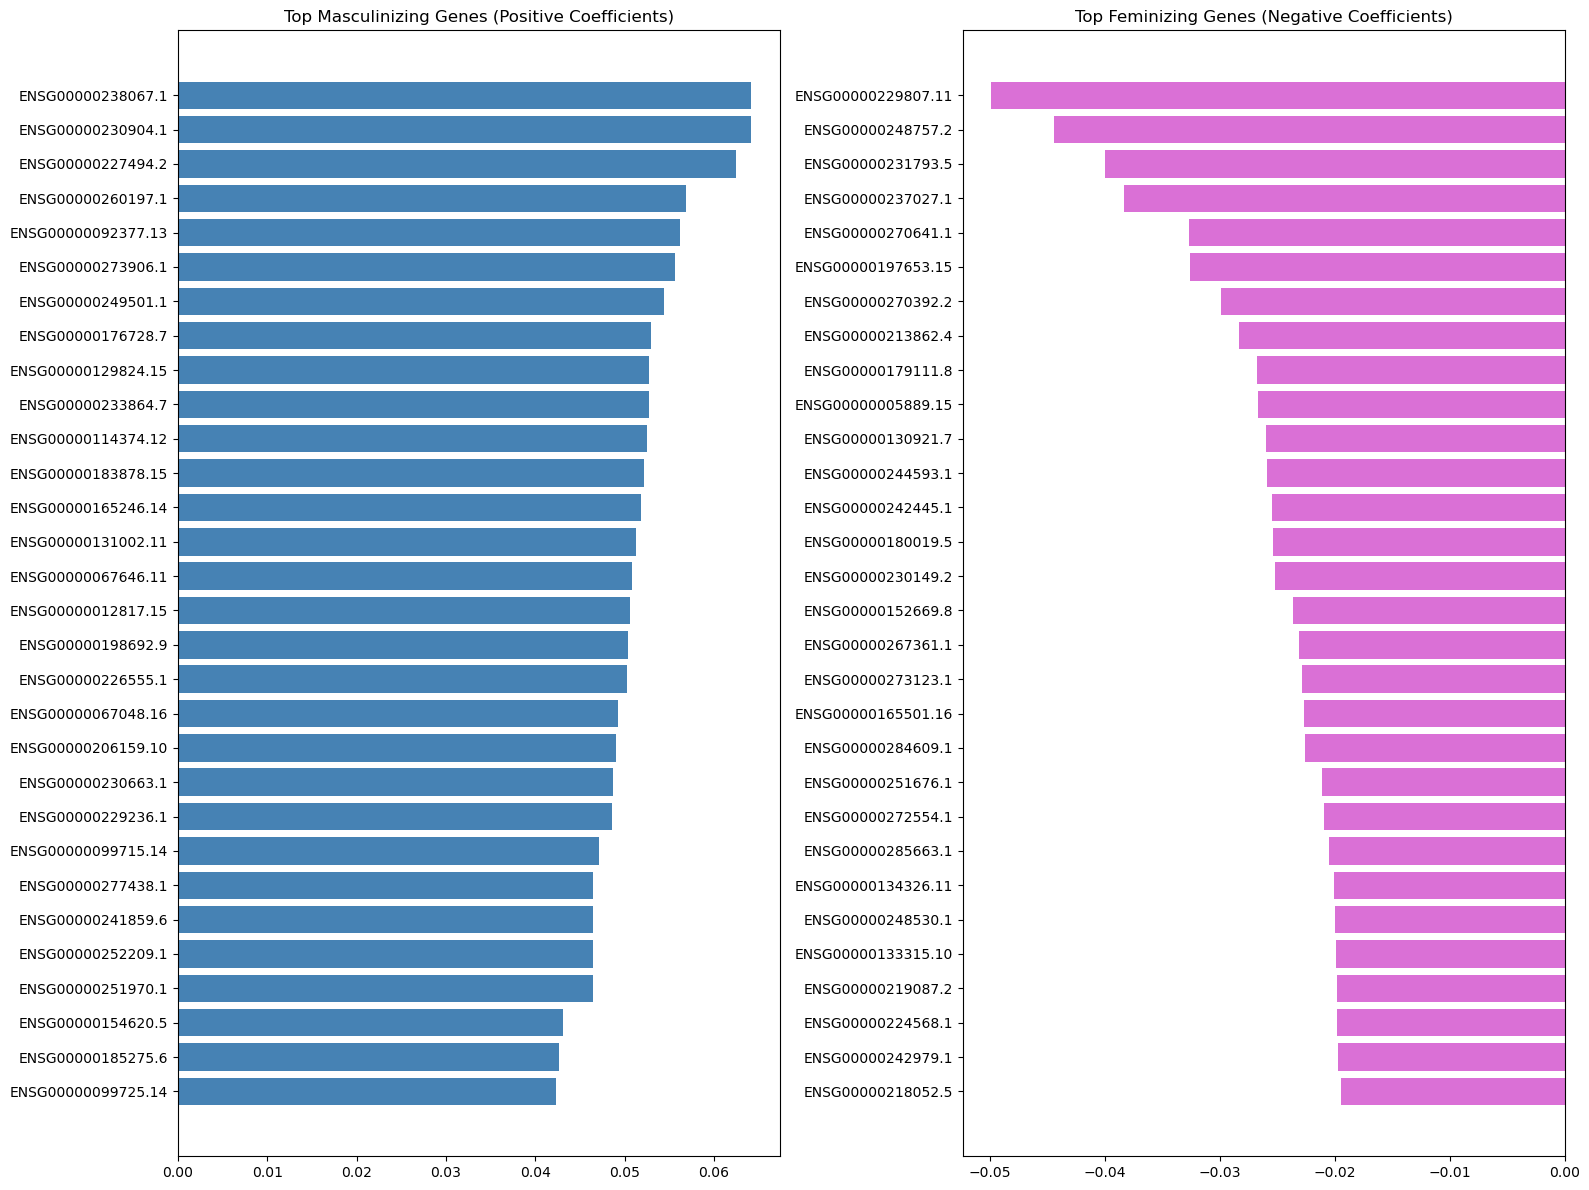

In [ ]:


import numpy as np

logreg_model = final_logreg.named_steps["model"]
pre = final_logreg.named_steps["preprocess"]

feature_names = pre.get_feature_names_out()
coef = logreg_model.coef_.flatten()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

print("Top 20 features by |coefficient|:")
display(coef_df.head(20))

# extract genes only
coef_genes = coef_df[coef_df["feature"].str.startswith("num__")].copy()
coef_genes["gene"] = coef_genes["feature"].str.replace("^num__", "", regex=True)

print("\nTop 20 genes:")
display(coef_genes.head(20))

# bar plots
coef_genes["direction"] = np.where(coef_genes["coef"] > 0, "male", "female")

top_masc = coef_genes[coef_genes["coef"] > 0].sort_values("coef", ascending=False).head(30)
top_fem  = coef_genes[coef_genes["coef"] < 0].sort_values("coef", ascending=True).head(30)


fig, axes = plt.subplots(1, 2, figsize=(16, 12))

axes[0].barh(np.arange(len(top_masc)), top_masc["coef"], color="steelblue")
axes[0].set_yticks(np.arange(len(top_masc)))
axes[0].set_yticklabels(top_masc["gene"])
axes[0].invert_yaxis()
axes[0].set_title("Top Masculinizing Genes (Positive Coefficients)")

axes[1].barh(np.arange(len(top_fem)), top_fem["coef"], color="orchid")
axes[1].set_yticks(np.arange(len(top_fem)))
axes[1].set_yticklabels(top_fem["gene"])
axes[1].invert_yaxis()
axes[1].set_title("Top Feminizing Genes (Negative Coefficients)")

plt.tight_layout()
plt.show()


## Random Seed Uncertainty Analysis

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from scipy.stats import loguniform, uniform

results = []
random_states = [0, 1, 2, 3, 4]

for seed in random_states:
    print(f"\n===== RANDOM SEED {seed} =====")


    # Train/Val/Test split for THIS seed
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=seed, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=seed, stratify=y_temp
    )


    # RSCV for THIS split
    search_seed = RandomizedSearchCV(
        estimator=make_logreg_pipeline(),
        param_distributions=param_dist,
        n_iter=40,
        scoring="average_precision",
        cv=5,
        random_state=seed,
        n_jobs=-1,
        verbose=0
    )
    search_seed.fit(X_train, y_train)

    # Validation PR-AUC
    val_probs = search_seed.best_estimator_.predict_proba(X_val)[:, 1]
    val_ap = average_precision_score(y_val, val_probs)

    # refit on Train+Val
    X_train_full = pd.concat([X_train, X_val], axis=0)
    y_train_full = pd.concat([y_train, y_val], axis=0)

    final_seed_model = make_logreg_pipeline()
    final_seed_model.set_params(**search_seed.best_params_)
    final_seed_model.fit(X_train_full, y_train_full)

    # test PR-AUC
    test_probs = final_seed_model.predict_proba(X_test)[:, 1]
    test_ap = average_precision_score(y_test, test_probs)

    results.append({
        "seed": seed,
        "cv_ap": search_seed.best_score_,
        "val_ap": val_ap,
        "test_ap": test_ap
    })

    print(f"CV={search_seed.best_score_:.4f} | VAL={val_ap:.4f} | TEST={test_ap:.4f}")

results_df = pd.DataFrame(results)
print("\n===== SUMMARY OF 5 SEEDS =====")
display(results_df)

print("\nMean Test PR-AUC:", results_df["test_ap"].mean())
print("Std Test PR-AUC:", results_df["test_ap"].std())



===== RANDOM SEED 0 =====


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

CV=0.7775 | VAL=1.0000 | TEST=0.5792

===== RANDOM SEED 1 =====


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

CV=0.8582 | VAL=0.9167 | TEST=0.6442

===== RANDOM SEED 2 =====


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

CV=0.8202 | VAL=0.6190 | TEST=0.9500

===== RANDOM SEED 3 =====


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

CV=0.8237 | VAL=0.6714 | TEST=0.8167

===== RANDOM SEED 4 =====


/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/esrataner/miniforge3/envs/data1030/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarni

CV=0.8808 | VAL=0.5515 | TEST=0.9167

===== SUMMARY OF 5 SEEDS =====


,seed,cv_ap,val_ap,test_ap
0,0,0.777515,1.000000,0.579167
1,1,0.858218,0.916667,0.644242
2,2,0.820226,0.619048,0.950000
3,3,0.823712,0.671429,0.816667
4,4,0.880833,0.551526,0.916667



Mean Test PR-AUC: 0.7813484848484848
Std Test PR-AUC: 0.16407108011365146


In [10]:
print("\n=== UNCERTAINTY SUMMARY (TEST PR-AUC) ===")
print(results_df["test_ap"].describe())

print("\nMean:", results_df["test_ap"].mean())
print("Std Dev:", results_df["test_ap"].std())
print("Min:", results_df["test_ap"].min())
print("Max:", results_df["test_ap"].max())



=== UNCERTAINTY SUMMARY (TEST PR-AUC) ===
count    5.000000
mean     0.781348
std      0.164071
min      0.579167
25%      0.644242
50%      0.816667
75%      0.916667
max      0.950000
Name: test_ap, dtype: float64

Mean: 0.7813484848484848
Std Dev: 0.16407108011365146
Min: 0.5791666666666666
Max: 0.95


In [ ]:
# make a folder to store outputs
os.makedirs("logreg_results", exist_ok=True)

# save the TEST performance summary table
results_df.to_csv("logreg_results/logreg_seed_performance.csv", index=False)

print("Saved: logreg_results/logreg_seed_performance.csv")


# save coefficients for each seed
coef_records = []

for seed_record in results:  
    seed = seed_record["seed"]

    # recreate the train/val split for this seed
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=seed, stratify=y
    )
    X_val, X_test_seed, y_val, y_test_seed = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=seed, stratify=y_temp
    )

    # r LR with the best params for this seed
    best_params = results_df.loc[results_df.seed == seed, :].iloc[0].to_dict()

    # actual params stored from RSCV
    best_params = search_seed.best_params_ if seed == seed_record["seed"] else best_params

    final_seed_model = make_logreg_pipeline()
    final_seed_model.set_params(**best_params)
    final_seed_model.fit(pd.concat([X_train, X_val]),
                         pd.concat([y_train, y_val]))

    # extract coefficients
    lr = final_seed_model.named_steps["model"]
    pre = final_seed_model.named_steps["preprocess"]
    feat = pre.get_feature_names_out()
    coef = lr.coef_.flatten()

    df_coef = pd.DataFrame({
        "seed": seed,
        "feature": feat,
        "coef": coef,
        "abs_coef": np.abs(coef)
    })

    # save per-seed coefficient table
    df_coef.to_csv(f"logreg_results/logreg_coef_seed_{seed}.csv", index=False)

    coef_records.append(df_coef)

print("Saved all seed-level LR coefficient tables.")

